In [2]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import math
from selenium import webdriver
import re
HOME = "https://www.youtube.com/user/theneedledrop/videos"

In [3]:
def scroll():
    """
    scrolls to the bottom of the page
    code taken from https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
    modified slightly for YouTube
    """
    SCROLL_PAUSE_TIME = 0.5

    last_height = driver.execute_script("return window.scrollY")

    tries = 0
    while True:
        down_height = last_height + 1000
        driver.execute_script("window.scrollTo(0," + str(down_height)  + ")")

        time.sleep(SCROLL_PAUSE_TIME)

        new_height = driver.execute_script("return window.scrollY")
        if new_height == last_height:
            tries += 1
            time.sleep(SCROLL_PAUSE_TIME)
            if tries == 50:
                break
        else:
            tries = 0
        last_height = new_height

In [314]:
#Scrape for videos
driver = webdriver.Chrome("C:\webdriver\chromedriver.exe")
driver.get(HOME)

scroll()
element_titles = driver.find_elements_by_id("video-title")

# Would be interesting to see if description pasting would work

In [315]:
#Creation of the data
row = []
GENRE_PATTERN = re.compile("[^\/](19|20)\d{2}\s\/.*")
PATTERN = re.compile('(?<=shortDescription":").*(?=","isCrawlable)')
for element in element_titles:
    title = element.text

#Not Good and Classics are included within this data
    try:
        if "review" in title.lower() and "track review" not in title.lower() and "yunoreview" not in title.lower() and "weekly track" not in title.lower():

            #Get Description of video
            soup = BeautifulSoup(requests.get(element.get_attribute("href")).content)
            description = PATTERN.findall(str(soup))[0].replace('\\n','\n').lower()

            #Get Score of the video
            score = re.search("[^201]\n\d{0,2}\/10", description).group().strip("\n").split("/")[0] #Prevents word classification to not be included (Classic, meh, Not Good)

            #Get the Genre
            genre = GENRE_PATTERN.search(description).group()

            #Get the year the album dropped
            album_date = GENRE_PATTERN.search(description).group().split("/")[0].strip()

            #Date of when the video was published
            video_date = soup.find("meta", itemprop="datePublished")['content']

            row.append([title,genre,album_date,video_date,score])
            print([title,genre,album_date,video_date,score])
    except Exception:
        pass

music_data = pd.DataFrame(row,columns=["Title", "Genre","Album_Date","Video_Date","Score"])

#Save the music data to csv
music_data.to_csv(r"C:\Users\David Salazar\Desktop\Python\NeedleDrop\music_data.csv")

KeyboardInterrupt: 

# Data Cleaning

In [321]:
#Fixed the data frame
music_data = pd.read_csv(r"C:\Users\David Salazar\Desktop\Python\NeedleDrop\music_data.csv", index_col=0,encoding='latin-1')

In [322]:

#Fix Score Counts and convert to numerics
music_data["Score"] = music_data["Score"].str.replace(".\\n","")
music_data["Score"] = pd.to_numeric(music_data["Score"])

C:\Users\David Salazar\AppData\Local\Temp\ipykernel_62916\167175455.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  music_data["Score"] = music_data["Score"].str.replace(".\\n","")


In [323]:
#Remove "{Name} Review From Title"
pattern_album = re.compile("(ALBUM|EP|MIXTAPE) .*", re.I)
music_data["Title"] = music_data["Title"].str.replace(pattern_album,"")
music_data["Title"] = music_data["Title"].str.replace("EP/","") #SZA- Z man

In [324]:
#Splitting title into artist and album
music_data[["Artist", "Album"]] = music_data["Title"].str.split(pat = "-",expand=True, n = 1)
del music_data["Title"]
music_data = music_data[["Artist", "Album", "Genre", "Album_Date", "Video_Date", "Score"]]

In [325]:
#Filter the sub-genre to the parent-genre
music_data["Genre"].mask( music_data["Genre"].str.contains("r&b|soul|funk",case=False, na=False), "R&B", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("hip hop|rap|trap|drill",case=False, na=False), "Rap", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("rock|punk|emo|screamo|grunge|metal|hardcore",case=False, na=False), "Rock", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("jazz|bop",case=False, na=False), "Jazz", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("electro|dub|synth|house|dance|disco|edm|glitch|idm",case=False, na=False), "Electronic", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("ambient",case=False, na=False), "Ambient", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("pop",case=False, na=False), "Pop", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("folk",case=False, na=False), "Folk", inplace=True )
music_data["Genre"].mask( music_data["Genre"].str.contains("country",case=False, na=False), "Country", inplace=True )

In [326]:
import dataframe_image as dfi
artists = music_data["Artist"].str.replace(" ","")
artists.value_counts().head(n=5)

Drake                          10
BigK.R.I.T.                     9
Logic                           9
Weezer                          8
KingGizzard&TheLizardWizard     8
Name: Artist, dtype: int64

In [284]:
print("Mr.Fantano has reviewed about " + str(music_data.shape[0]) + " albums/ep/mixtape as of 5/22/2022 => 1/21/2011 ") #Not including classics, Not Good, and

Mr.Fantano has reviewed about (2064, 6) albums/ep/mixtape as of 5/22/2022 => 1/21/2011 


Mr.Fantano has been uploading reviews since 2011 and on average releases 172 reviews per year


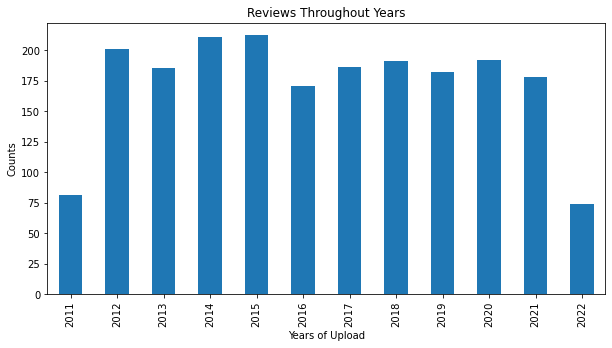

In [286]:
music_data["Video_Date"] = pd.to_datetime(music_data["Video_Date"])
music_data["Video_Date"].dt.year.value_counts().sort_index().plot(kind="bar",xlabel="Years of Upload", ylabel="Counts",title="Reviews Throughout Years", figsize=(10,5))
print( "Mr.Fantano has been uploading reviews since 2011 and on average releases " +
       str( math.ceil( music_data["Video_Date"].dt.year.value_counts().mean() ) ) +" reviews per year")

## Bar Chart w/ all scores

count    2064.000000
mean        6.315891
std         1.597690
min         0.000000
25%         5.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: Score, dtype: float64

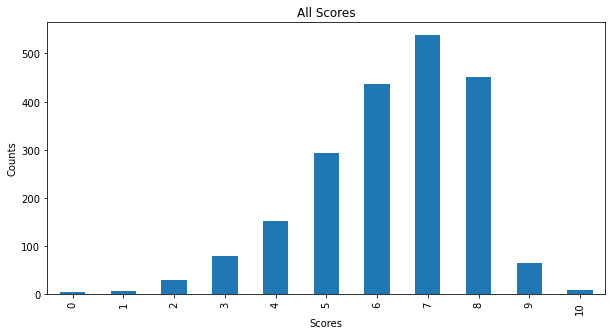

In [306]:
music_data["Score"].value_counts().sort_index().plot(kind="bar",xlabel="Scores", ylabel="Counts",title="All Scores", figsize=(10,5))
music_data["Score"].describe()

# What is the average per genre? (Size > 30)

In [269]:
music_data["Genre"].value_counts().head(n=6)

Rock          725
Rap           559
R&B           286
Electronic    195
Pop           128
Folk           43
Name: Genre, dtype: int64

Rap Scores:



count    559.000000
mean       6.087657
std        1.706358
min        0.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: Score, dtype: float64

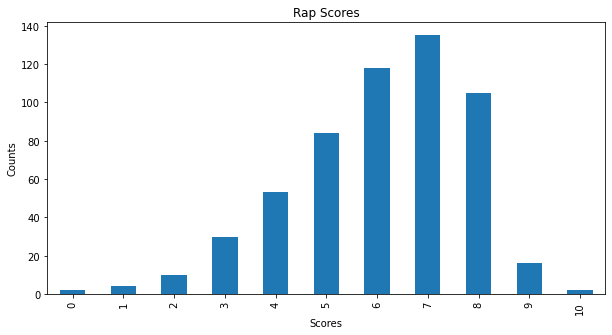

In [307]:
#Rap
rap = music_data [music_data["Genre"] == "Rap"]
rap.reset_index(drop=True)
rap["Score"].value_counts().sort_index().plot(kind="bar",xlabel="Scores", ylabel="Counts",title="Rap Scores", figsize=(10,5))
print("Rap Scores:\n")
rap["Score"].describe()

Rock Scores:



count    725.000000
mean       6.477241
std        1.448410
min        1.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: Score, dtype: float64

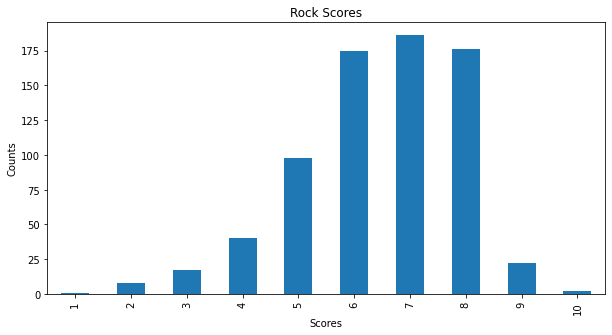

In [308]:
#Rock
rock = music_data [music_data["Genre"] == "Rock"]
rock.reset_index(drop=True)
rock["Score"].value_counts().sort_index().plot(kind="bar",xlabel="Scores", ylabel="Counts",title="Rock Scores", figsize=(10,5))
print("Rock Scores:\n")
rock["Score"].describe()

Pop Scores:



count    128.000000
mean       6.171875
std        1.707369
min        2.000000
25%        5.000000
50%        7.000000
75%        7.000000
max       10.000000
Name: Score, dtype: float64

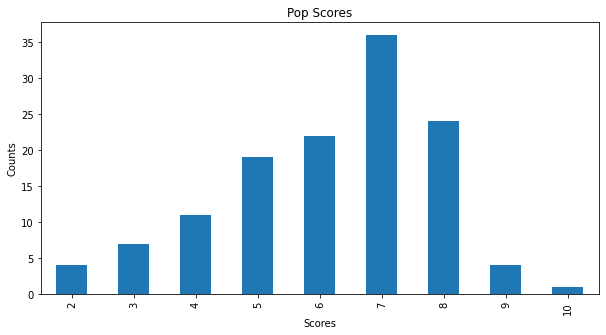

In [309]:
#Pop
pop = music_data [music_data["Genre"] == "Pop"]
pop.reset_index(drop=True)
pop["Score"].value_counts().sort_index().plot(kind="bar",xlabel="Scores", ylabel="Counts",title="Pop Scores", figsize=(10,5))
print("Pop Scores:\n")
pop["Score"].describe()

R&B Scores:



count    286.000000
mean       6.062937
std        1.731916
min        1.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: Score, dtype: float64

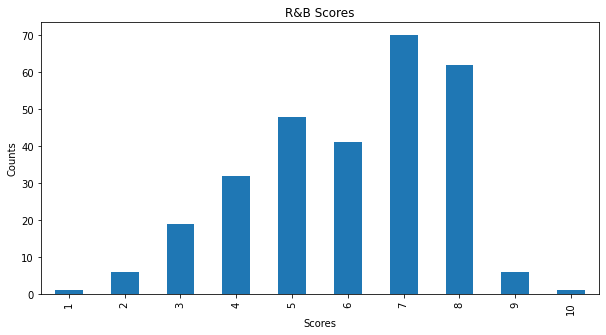

In [310]:
#R&B
RB = music_data [music_data["Genre"] == "R&B"]
RB.reset_index(drop=True)
RB["Score"].value_counts().sort_index().plot(kind="bar",xlabel="Scores", ylabel="Counts",title="R&B Scores", figsize=(10,5))
print("R&B Scores:\n")
RB["Score"].describe()

Electronic Scores:



count    195.000000
mean       6.379487
std        1.512692
min        0.000000
25%        6.000000
50%        7.000000
75%        7.000000
max       10.000000
Name: Score, dtype: float64

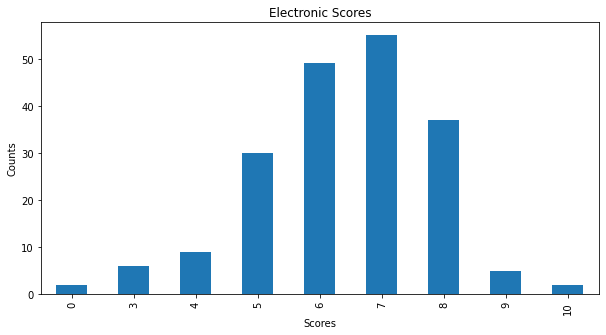

In [311]:
electronic = music_data [music_data["Genre"] == "Electronic"]
electronic.reset_index(drop=True)
electronic["Score"].value_counts().sort_index().plot(kind="bar",xlabel="Scores", ylabel="Counts",title="Electronic Scores", figsize=(10,5))
print("Electronic Scores:\n")
electronic["Score"].describe()

Electronic Scores:



count    43.000000
mean      7.000000
std       1.253566
min       4.000000
25%       6.000000
50%       7.000000
75%       8.000000
max       9.000000
Name: Score, dtype: float64

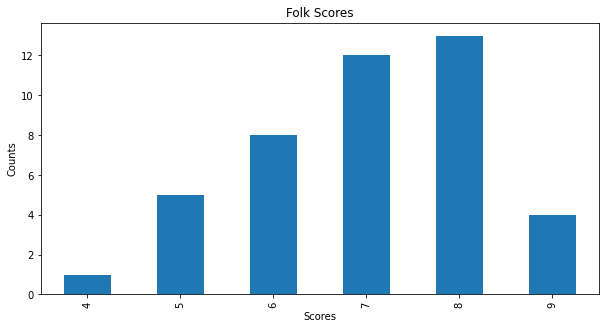

In [312]:
folk = music_data [music_data["Genre"] == "Folk"]
folk.reset_index(drop=True)
folk["Score"].value_counts().sort_index().plot(kind="bar",xlabel="Scores", ylabel="Counts",title="Folk Scores", figsize=(10,5))
print("Electronic Scores:\n")
folk["Score"].describe()

# Is there a bias within Mr.Fantano's review?
> There has been a large discussion online that Mr.Fantano doesn't like rap and is a big metal/rock fan

In [276]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
f_stats, p_value = stats.f_oneway(rap["Score"],rock["Score"],pop["Score"],RB["Score"], electronic["Score"],folk["Score"])
if p_value < 0.05:
    print("Means are not equal " + str( format(p_value, '.10f')) + " Meaning that some bias is going on!\n")

combined = pd.concat([rap,rock,pop,RB,electronic,folk], axis = 0, ignore_index=True)

Means are not equal 0.0000018578 Meaning that some bias is going on!



In [278]:
poc_hoc = pairwise_tukeyhsd(endog = combined["Score"], groups = combined["Genre"] ,alpha=.05)
print(poc_hoc)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1   group2 meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Electronic   Folk   0.6205 0.1878 -0.1436  1.3846  False
Electronic    Pop  -0.2076 0.8612 -0.7235  0.3083  False
Electronic    R&B  -0.3166 0.2652 -0.7377  0.1046  False
Electronic    Rap  -0.2918 0.2349  -0.669  0.0854  False
Electronic   Rock   0.0978 0.9737 -0.2681  0.4636  False
      Folk    Pop  -0.8281 0.0372 -1.6275 -0.0287   True
      Folk    R&B  -0.9371 0.0043 -1.6789 -0.1953   True
      Folk    Rap  -0.9123  0.004 -1.6301 -0.1946   True
      Folk   Rock  -0.5228 0.2903 -1.2346  0.1891  False
       Pop    R&B  -0.1089 0.9876 -0.5912  0.3734  False
       Pop    Rap  -0.0842 0.9945 -0.5286  0.3602  False
       Pop   Rock   0.3054 0.3407 -0.1295  0.7402  False
       R&B    Rap   0.0247 0.9999  -0.305  0.3544  False
       R&B   Rock   0.4143 0.0027  0.0976   0.731   True
       Rap   Rock   0.3896 0.00